In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
import keras.layers as layers

import numpy as np
import os
import subprocess
import pickle

import tokenizing
from frequency_analysis import get_prob


print('TensorFlow version: {}'.format(tf.__version__))

2023-06-09 11:50:44.303939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

ImportError: cannot import name 'read_list' from 'get_config' (/Users/alekss/Desktop/reviews_project/get_config.py)

fake_len_all:  300
fake_len_train:  240
fake_len_test:  60
not_fake_len_all:  2823
not_fake_len_train:  1080
not_fake_len_test:  180
<class 'numpy.ndarray'>
<class 'numpy.int64'>


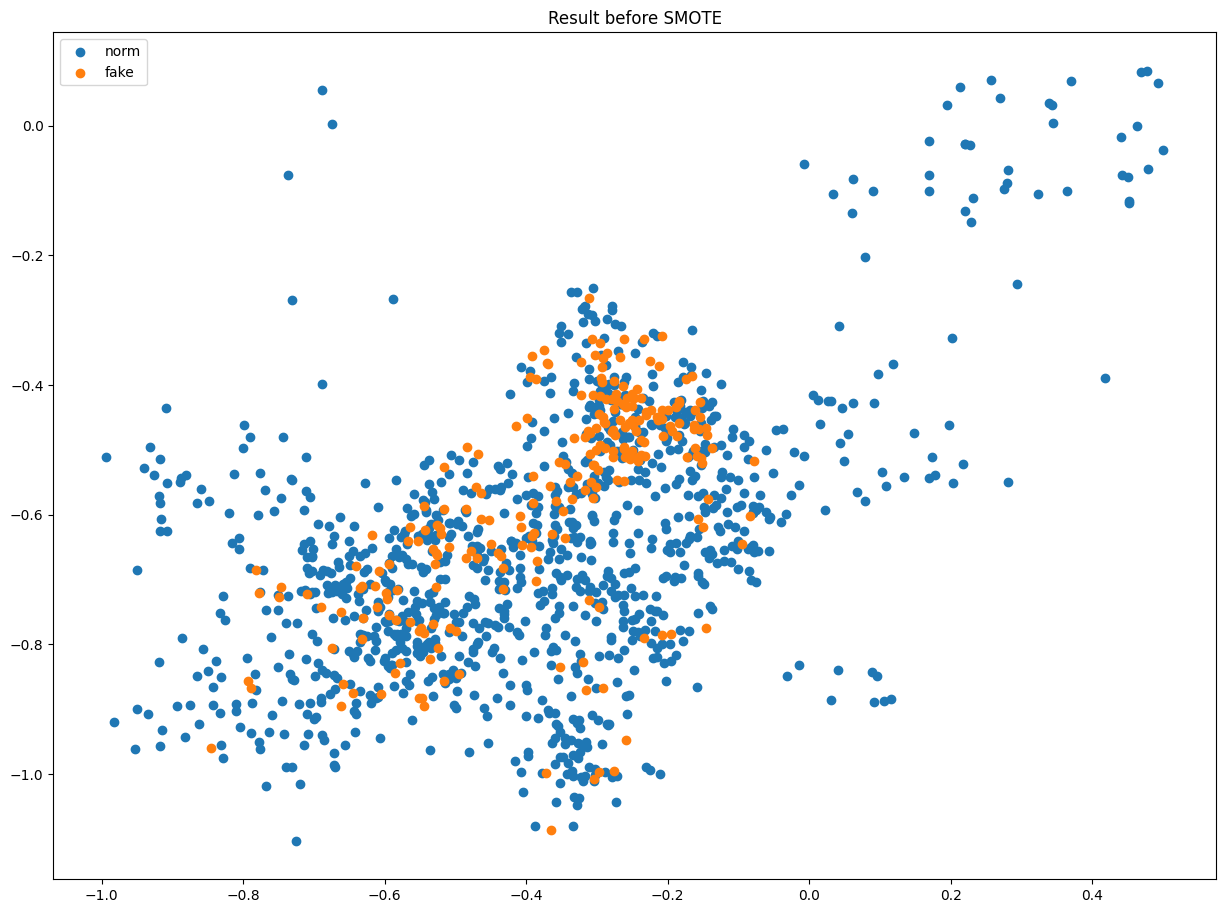

<class 'numpy.ndarray'>
<class 'numpy.int64'>


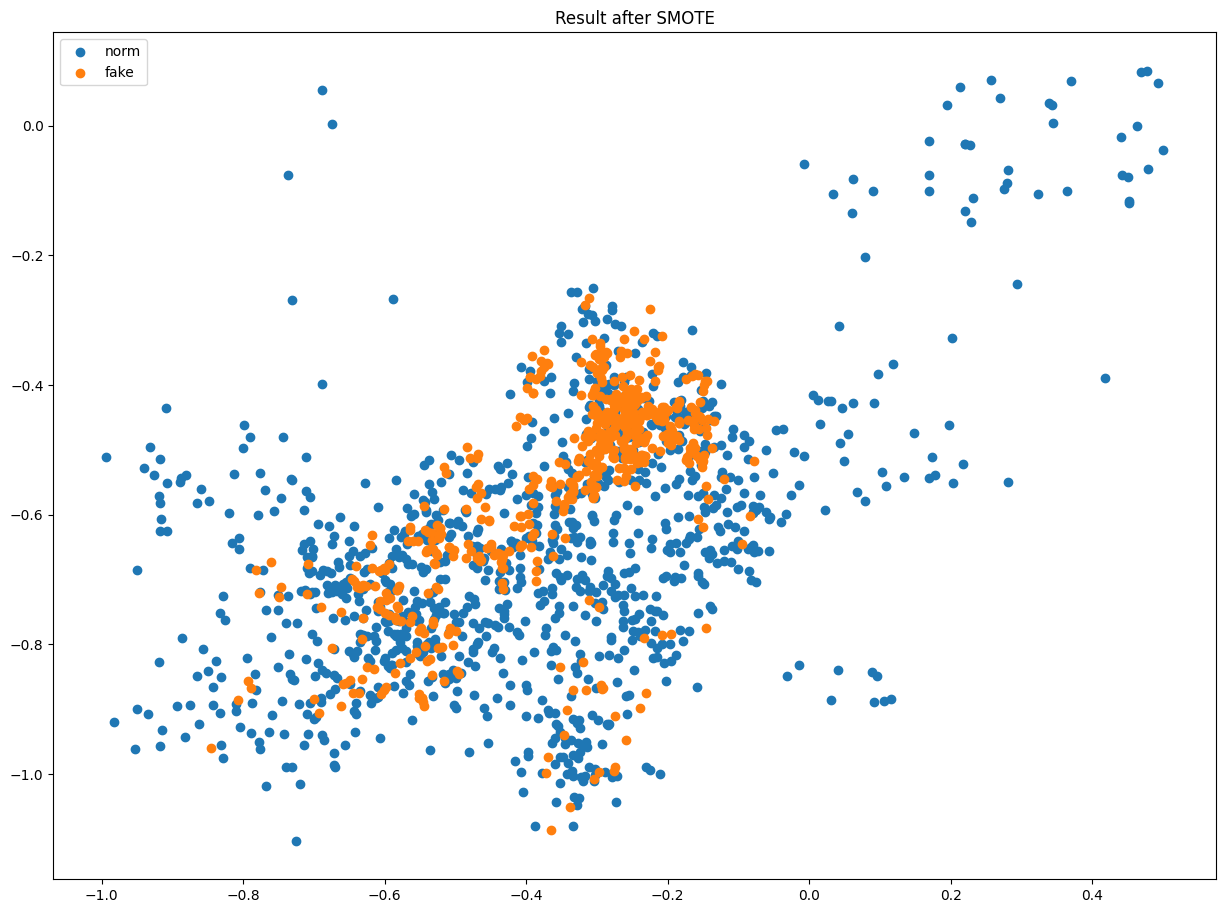

In [1]:
from db_actions import DatabaseActions as db
from structure.train_data import StoredData
import matplotlib.pyplot as plt


data = db.get_parsed()

storedData = StoredData(data, 
                        do_smote=True,
                        smote_ratio=0.6,
                        class_ratio=4.5,
                        test_ratio=0.8)


X_t = storedData.x_train.reshape((len(storedData.x_train), 768))
y_t = storedData.y_train

print(type(X_t[0]))
print(type(y_t[0]))

plt.figure(figsize=(15, 11))
plt.title('Result after SMOTE')
plt.scatter(X_t[y_t==0][:, 0], X_t[y_t==0][:, 1], label='norm')
plt.scatter(X_t[y_t==1][:, 0], X_t[y_t==1][:, 1], label='fake')
plt.legend()
plt.grid(False)
plt.show()

In [2]:
print(storedData.x_train.shape)
print(type(storedData.x_train[0]), len(storedData.x_train[0]))
print(type(storedData.x_train[0][0]))
print(type(storedData.x_train), len(storedData.x_train))
print(type(storedData.y_train), len(storedData.y_train))
print(type(storedData.y_train[0]))

(1728, 24, 32)
<class 'numpy.ndarray'> 24
<class 'numpy.ndarray'>
<class 'numpy.ndarray'> 1728
<class 'numpy.ndarray'> 1728
<class 'numpy.int64'>


In [ ]:
import tensorflow as tf

# Create a simple CNN model
def create_cnn_model(input_shape):
    model = tf.keras.Sequential()
    
    # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
    model.add(layers.Conv2D(256, (9, 9), activation='tanh', input_shape=input_shape))


    model.add(layers.Dense(256, activation='tanh'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='tanh'))

    # Max pooling layer with 2x2 pool size
    model.add(layers.MaxPooling2D((3, 3)))
    
    # Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    model.add(layers.Conv2D(512, (4, 4), activation='tanh'))

    model.add(layers.Dense(256, activation='tanh'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='tanh'))
    
    # Max pooling layer with 2x2 pool size
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the output from the previous layer
    model.add(layers.Flatten())
    
    # Fully connected layer with 64 units and ReLU activation
    model.add(layers.Dense(256, activation='tanh'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='tanh'))
    
    # Output layer with 1 unit and sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Create an instance of the model
input_shape = (24, 32, 1) # Example shape, adjust based on your data
model = create_cnn_model(input_shape)

# Compile the model
# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(curve='ROC')])
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[ tf.keras.metrics.AUC(curve='ROC'),
                        keras.metrics.Precision(name='precision'),
                        keras.metrics.Recall(name='recall')])                                      

# Print the model summary
model.summary()


In [ ]:

model.fit(storedData.x_train, storedData.y_train, epochs=30, verbose=1)

res = model.predict(storedData.x_test)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def find_optimal_threshold(pred_probs, y_true):
    low = 0.0  # Lowest possible threshold value
    high = 1.0  # Highest possible threshold value
    epsilon = 1e-6  # Small value for threshold precision
    best_threshold = 0.2  # Initial threshold value
    best_accuracy = 0.0  # Initial best accuracy

    while low <= high:
        threshold = (low + high) / 2.0  # Calculate the mid-point threshold

        # Convert predicted probabilities into binary predictions using the threshold
        predictions = [1 if prob >= threshold else 0 for prob in pred_probs]

        # Calculate accuracy using the binary predictions and true labels
        accuracy = accuracy_score(y_true, predictions)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

        if accuracy + epsilon >= best_accuracy:
            low = threshold + epsilon
        else:
            high = threshold - epsilon

    return best_threshold, best_accuracy

find_optimal_threshold(res, storedData.y_test)

In [ ]:
# for i in range(95, 105):
#     print(i, y_train[i], texts[i], sep= '\t', end='\t')
#     print()

print(storedData.y_test)

ct = 0
for i in range(len(storedData.y_test)):
    if storedData.y_test[i] == 0:
        ct += 1
ct2 = 0
for i in range(len(res)):
    if res[i] >= 0.5:
        ct2 += 1

print(ct)
print(ct2)
# dif = np.median(res)
dif, b_a = find_optimal_threshold(res, storedData.y_test)

print(dif, b_a)
dif = 0.5

c = 0
for i in range(len(storedData.x_test)):
    if (res[i] > dif) == storedData.y_test[i]:
        print("YES", res[i] > dif, storedData.y_test[i], res[i])
        c += 1
    else:
        print("NO", res[i] > dif, storedData.y_test[i], res[i])
print(c, len(storedData.x_test))
print(c / len(storedData.x_test))

In [ ]:
for i in range(len(storedData.x_test)):
    print("да" if (res[i] > dif) == storedData.y_test[i] else "нет", res[i], res[i] > dif, storedData.y_test[i], storedData.texts_test[i], sep='\t')


In [5]:

def check_review(text):

    vector = tokenizing.tokenize_one(text) 
    print(vector.shape)
    vector = vector.reshape((24, 32))
    print('~' * 80)
    # print(vector)
    return(model.predict(np.array([vector,])))

txt1 = "Невероятно уютное и атмосферное место. Здесь прекрасно всё: меню, винная карта, сервис. В заведении два этажа - на первом атмосфера бара, на втором - ресторана, мягкий уютный свет, приятная публика, ненавязчивая музыка и интерьер. Это место с историей - здание построено в 1908 году (отсюда и название), а заведение находится в настоящей арке, под сводами которой стоят столики. Здесь приятно поужинать и прийти на завтрак, забежать на обед. Обстановка как бы обнимает тебя и погружает в стиль и уют. Здесь получаются очень стильные фото 😉 Еда вкусная, приносят быстро. Мне всегда хочется сюда возвращаться снова и снова"
txt2 = "Недавно посетила с моими гостями ресторан «Сунели». Порекомендовали друзья как маленький уголок Грузии со вкусной кухней и доброжелательным персоналом. Было всё намного лучше, чем ожидали. Красивый интерьер, тихая фоновая музыка, приятная обстановка настроили на позитивный настрой с первой минуты. А вкусная еда, отличные десерты с кофе подтвердили мое решение прийти сюда ещё не раз. Рекомендую всем, кто любит грузинскую кухню, ненавязчивый персонал и приятные цены!"
txt3 = "Я постаянный клиент постаянно приежаю кушаю постаянно не обрашаеть внимания к клиенту ждешь ждешь ждешь сами ходят три четыре человек не один из них не смотрит что клиент пришел сель уже ждет обясните пожалуйста официантам чтобы они внимательно смотрели один раз приехал по кушать казань кебаб баранина они мне привизли одни жыр я просил можно мясо жыр не могу кушать они привизли мясо холодный даже не погрел обьясните пожалуйста спасибо"
txt4 = "Интересное, романтичное заведение! По выходным, начиная с пятнице, проходят хорошие тусовочки с интересной музыкой. Еда и цена, как везде."
txt5 = "Зашли с другом в Ламбик 28 марта, на входе встретила милая и доброжелательная девушка администратор, предложила уютный столик у окна. Официантка подошла быстро, помогла определиться с выбором и достаточно оперативно заказ нам принесла. Общее впечатление от ресторана - небольшое уютное заведение, как раз в стиле заведений того района (Патриаршие пруды), и такая камерность делает ресторан очень симпатичным и не пафосным. Пиво вкусное, сервис на уровне. В общем, нам понравилось. Спасибо Ламбику и менеджеру Ларисе, обязательно вернёмся)"

r1 = check_review(txt1)
r2 = check_review(txt2)
r3 = check_review(txt3)
r4 = check_review(txt4)
r5 = check_review(txt5)
print(dif)
print("~" * 80)
print(dif <= r1, r1)
print(dif <= r2, r2)
print(dif <= r3, r3)
print(dif <= r4, r4)
print(dif <= r5, r5)

AttributeError: 'str' object has no attribute 'text'

In [ ]:
tmp = check_review("идеальшейшая корчма -- она очень сильно понравится. для истинных гурманов")

print(dif <= tmp, tmp, dif)


In [ ]:
from frequency_analysis import texts
# print(texts)


data = []

for i in range(len(texts)):
    data.append(get_prob(texts[i]))

import matplotlib.pyplot as plt

d1 = np.array(data[0:100])
d1.sort()
# d1 = d1[0:90]

d2 = np.array(data[100:200])
d2.sort()

# d2 = d2[0:90]
# Create a line plot


In [ ]:
plt.plot(d1, label="fake")
plt.plot(d2, label="real")

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Array Data Visualization')

# Display the plot
plt.legend()
plt.show()

print("fake", np.median(d1), np.average(d1))
print("normal", np.median(d2), np.average(d2))

In [ ]:
# np.seterr('raise') 
d3 = []
s = 0.0
for i in range(1, len(d1)):
    print(d1[i], d2[i])
    s = s + d1[i] / d2[i]
    d3.append(s)
print(d3)
plt.plot(d3)
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Array Data Visualization')

# Display the plot
plt.show()

In [ ]:
# np.seterr('raise') 
d4 = []
d1[:] = d1[::-1]
d2[:] = d2[::-1]
s = 0.0
for i in range(1, len(d1)):
    s = s + d1[i]
    d4.append(s)

plt.plot(d4, label="fake")

d5 = []
s = 0.0
for i in range(1, len(d1)):

    s = s + d2[i]
    d5.append(s)

plt.plot(d5, label="real")
plt.legend()
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Array Data Visualization')

# Display the plot
plt.show()

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


lr_probs = model.predict(storedData.x_test)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]

ns_probs = [0 for _ in range(len(storedData.y_test))]

# calculate scores
ns_auc = roc_auc_score(storedData.y_test, ns_probs)
lr_auc = roc_auc_score(storedData.y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

ns_fpr, ns_tpr, _ = roc_curve(storedData.y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(storedData.y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
# import os

# model.summary()
# model.save('model-06062023.h5')
# print('Saved model to disk')